In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from zigzag import *
from zigzag.plotting import *

Given,

In [2]:
X = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6])

the pre-`0.3.0` behavior of `ZigZag` would produce the following with `(0.2, -0.2)` thresholds,

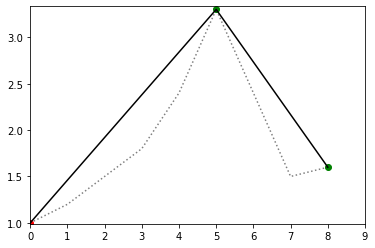

In [3]:
pivots = peak_valley_pivots_detailed(X, 0.2, -0.2, True, False)
plot_pivots(X, pivots)

As [ytian wrote in PR#3](https://github.com/jbn/ZigZag/pull/13), this looks like a bug for the last point which is clearly above the lowest point on the last segment. Consequently, `ytian` proposed the following behavior,

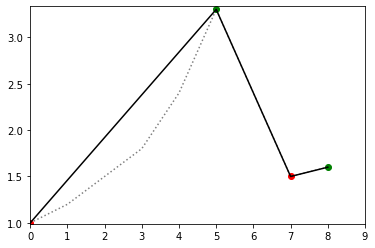

In [4]:
pivots = peak_valley_pivots_detailed(X, 0.2, -0.2, True, True)
plot_pivots(X, pivots)

But this has its own problem. **What happens if, the series goes further down after the final period?**

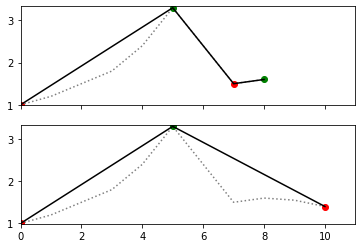

In [5]:
X = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6])
Y = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6, 1.55, 1.4])

_, ax = plt.subplots(2, 1, sharex=True, sharey=True)
plot_pivots(X, peak_valley_pivots_detailed(X, 0.2, -0.2, True, True), ax=ax[0])
plot_pivots(Y, peak_valley_pivots_detailed(Y, 0.2, -0.2, True, True), ax=ax[1])

Under the new proposed behavior, there is a phantom segment. The final valley-to-peak never exceeded the threshold required to be marked as such. When there was a further decline, it disappeared. 

However, if there was a further increase, the proposed change looks more intuitive.

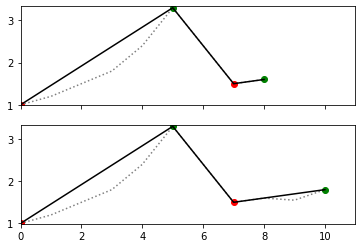

In [6]:
X = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6])
Y = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6, 1.55, 1.8])

_, ax = plt.subplots(2, 1, sharex=True, sharey=True)
plot_pivots(X, peak_valley_pivots_detailed(X, 0.2, -0.2, True, True), ax=ax[0])
plot_pivots(Y, peak_valley_pivots_detailed(Y, 0.2, -0.2, True, True), ax=ax[1])

Replicating this edge-case but in the other mode just to confirm expectations,

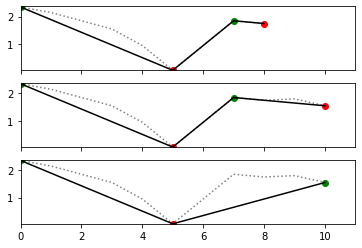

In [7]:
X = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6])
Y = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6, 1.55, 1.8])
Z = np.array([1, 1.2, 1.5, 1.8, 2.4, 3.3, 2.4, 1.5, 1.6, 1.55, 1.4])

X = X.max() - X + 0.05
Y = Y.max() - Y + 0.05
Z = Z.max() - Z + 0.05


_, ax = plt.subplots(3, 1, sharex=True, sharey=True)
plot_pivots(X, peak_valley_pivots_detailed(X, 0.2, -0.2, True, True), ax=ax[0])
plot_pivots(Y, peak_valley_pivots_detailed(Y, 0.2, -0.2, True, True), ax=ax[1])
plot_pivots(Y, peak_valley_pivots_detailed(Z, 0.2, -0.2, True, True), ax=ax[2])

Restated: if we eagerly switch the final segment's mode before it resolves according to the specified thresholds, its more accurate when it eventually resolves in that direction and less accurate when it does not. Which is not very helpful.

Looking at my previous documentation for this function,

>    The First and Last Elements
>    
>    The first and last elements are guaranteed to be annotated as peak or
>    valley even if the segments formed do not have the necessary relative
>    changes. This is a tradeoff between technical correctness and the
>    propensity to make mistakes in data analysis. The possible mistake is
>    ignoring data outside the fully realized segments, which may bias
>    analysis.

which is also not very helpful because it only anticipates one type of error in bias. There is always a trade-off.

In retrospect, I believe I made a mistake in the original specification, but not in the way `ytian` corrected. What to do with the final segment which is necessarily ambiguous demands an explicit decision. In fact, if there is to be a "sensible default" I now would lean towards no final annotation. That is, I would have opted for,

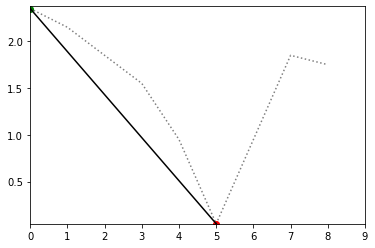

In [8]:
plot_pivots(X, peak_valley_pivots_detailed(X, 0.2, -0.2, False, True))

which limits you only to the **finalized** segments -- those which cannot change with additional observations.

# To answer:

- Which is more wrong: misidentifying which points are the peaks and valleys or misidentifying the mode of a segment?

- There are a lot of people using `ZigZag` so I cannot change the behavior. Even a few breaking semver would be a foul because it could accidentally induce model drift which is kinda fucked up.